# Predicting Molecular Energies with Artificial Neural Networks: 
# An Application to the ANI-1 Dataset 




----

### Table of Contents

1. [Introduction](#Introduction)
2. [Data Processing](#Data-Processing)
3. [Model Definition](#Model-Definition)
4. [Training](#Training)
5. [Output Analysis/Visualization](#Output-Analysis/Visualization)
6. [Conclusion](#Conclusion)


----

## Introduction

The purpose of this project is to develop a machine learning model for predicting the energy of molecules using the ANI (Atomic Neural Network) framework. In this report, we will present the details of the project, including the data processing steps, model definition, training process, and analysis of the model's performance.

### Project Goals

The main objectives of this project are:

1. Understand the ANI framework and its application in molecular energy prediction.
2. Implement and train a machine learning model based on the ANI architecture.
3. Evaluate the model's performance and analyze its predictions.
4. Provide insights into the potential applications and limitations of the model.

Throughout the report, we will provide clear explanations, code snippets, and visualizations to facilitate understanding and reproducibility. Let's dive into the details and explore the exciting world of molecular energy prediction with ANI!


----

# Data Processing

In this section, we will cover the steps involved in processing the input data for our model training. The data processing phase includes tasks such as loading the dataset, preprocessing, and splitting it into training and testing sets.


In [1]:
import numpy as np
import torch
from torch import nn
import torchani
import pyanitools as pya
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import math
import tqdm
import pickle
import os

# helper function to convert energy unit from Hartree to kcal/mol
from torchani.units import hartree2kcalmol


# device to run the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### ANI Dataset

The ANI-1 dataset is a widely-used benchmark dataset in computational chemistry that contains 57,000 organic molecules with up to 8 heavy atoms (carbon, nitrogen, oxygen, sulfur). The dataset provides the Cartesian coordinates of the atoms in each molecule, as well as their total energy calculated from quantum mechanical simulations using density functional theory (DFT). The ANI-1 dataset has been used extensively for developing and testing machine learning models for predicting molecular energies, as it provides a diverse set of molecules with varying chemical properties and complexity. Due to its relatively small size and simplicity, the ANI-1 dataset is often used as a starting point for developing and testing new machine learning models in computational chemistry.

### Loading the Dataset

To load the ANI-1 dataset, we will use the `pyanitools` library. The following code imports the dataset:

In [2]:
# Load ANI-1 dataset with 1 heavy atom
ani_data = pya.anidataloader("ANI-1_release/ani_gdb_s05.h5")

### Exploring the ANI Dataset

In this section, we will explore the ANI dataset and examine the contents of each data point. The ANI-1 dataset is a collection of organic molecules with up to 8 heavy atoms, and it provides various information such as the molecular coordinates, energies, species, and SMILES representation.

#### Dataset Contents

We will loop over each data point in the dataset and extract the following information for analysis:

- **Path:** The path or identifier of the data point in the dataset.
- **SMILES:** The simplified molecular-input line-entry system representation of the molecule.
- **Symbols:** The atomic symbols present in the molecule.
- **Coordinates:** The Cartesian coordinates of the atoms in the molecule.
- **Energies:** The total energies of the molecule.

Let's take a look at a few examples from the dataset:

In [3]:
# Loop over the first three molecules in the dataset
for i, mol in enumerate(ani_data):
    if i >= 3:
        break

    # Extract information from the dataset
    path = mol['path']
    coordinates = mol['coordinates']
    energies = mol['energies']
    species = mol['species']
    smiles = mol['smiles']

    # Print the information for this molecule
    print(f"Molecule {i + 1}:")
    print("  Path:         ", path)
    print("  SMILES:       ", "".join(smiles))
    print("  Symbols:      ", species)
    print("  Coordinates:  ", coordinates.shape)
    print("  Energies:     ", energies.shape, "\n")

# Close the H5 data file
ani_data.cleanup()

Molecule 1:
  Path:          /gdb11_s05/gdb11_s05-0
  SMILES:        [H]N([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
  Symbols:       ['C', 'C', 'C', 'C', 'N', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
  Coordinates:   (10080, 16, 3)
  Energies:      (10080,) 

Molecule 2:
  Path:          /gdb11_s05/gdb11_s05-1
  SMILES:        [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
  Symbols:       ['C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
  Coordinates:   (9360, 15, 3)
  Energies:      (9360,) 

Molecule 3:
  Path:          /gdb11_s05/gdb11_s05-10
  SMILES:        [H]OC([H])([H])C([H])(O[H])C([H])([H])[H]
  Symbols:       ['C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
  Coordinates:   (7920, 13, 3)
  Energies:      (7920,) 



### Atomic Environment Vectors (AEVs)

Atomic Environment Vectors (AEVs) are feature vectors that encode the local chemical environment around an atom in a molecule. These vectors play a crucial role in predicting molecular properties as they allow us to transform the initial atomic configurations using symmetry functions before inputting them into a neural network. By computing AEVs, we ensure that the neural network remains invariant to translations, rotations, and permutations of the atoms in a molecule.

To calculate AEVs for molecular structures, the torchani library provides a module called AEV Computer. This class is initialized with various parameters and hyperparameters, which determine how the AEVs are computed. The parameters include the cutoff radius for radial symmetry functions (Rcr) and the cutoff radius for angular symmetry functions (Rca). The hyperparameters include EtaR, EtaA, Zeta, ShfR, ShfA, and ShfZ, which are used in the computation of the AEVs.

Using AEVs offers several benefits, including improved accuracy and efficiency of the neural network for predicting molecular properties. By capturing the local chemical environment around each atom, the neural network can effectively learn the relationships between the atomic configurations and the corresponding properties.

In our implementation, we define the AEV Computer with the specified hyperparameters:

In [4]:
# AEV Computer hyperparameters
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)

species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order) # number of different atom symbols

aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
energy_shifter = torchani.utils.EnergyShifter(None)

In the above code, we initialize the AEV Computer with the specified hyperparameters, including the cutoff radii, Eta values, shift values, and Zeta values. Additionally, we provide the order of the atom symbols (species_order) and the total number of different atom symbols (num_species).

By using the AEV Computer, we can calculate AEVs for the atoms in our molecular structures, which will be used as input features for our neural network model in the subsequent steps of our workflow.

### Preprocessing and Splitting a Dataset for Training and Validation

This is the preprocessing and splitting of the ANI-1 (subset of 5 heavy atoms) dataset into training and validation sets. The dataset is loaded from a specified file, and if a preprocessed dataset is not found, it undergoes preprocessing steps including subtracting self-energies and species mapping. The processed dataset is then shuffled and split into 80% for training and 20% for validation. The data is collated into batches, cached, and saved as a pickled file. The self atomic energies and the number of data points in the training and validation sets are printed for reference.

In [5]:
# Determine the current working directory
try:
    path = os.path.dirname(os.path.realpath(__file__))
except NameError:
    path = os.getcwd()

# Set the path to the dataset file
dspath = os.path.join(path, 'ANI-1_release/ani_gdb_s05.h5')
batch_size = 2560

pickled_dataset_path = 'dataset.pkl'

# Check if a preprocessed dataset is available
if os.path.isfile(pickled_dataset_path):
    print(f'Unpickling preprocessed dataset found in {pickled_dataset_path}')
    with open(pickled_dataset_path, 'rb') as f:
        dataset = pickle.load(f)
    training = dataset['training'].collate(batch_size).cache()
    validation = dataset['validation'].collate(batch_size).cache()
    energy_shifter.self_energies = dataset['self_energies'].to(device)
else:
    print(f'Processing dataset in {dspath}')
    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter)
    dataset = dataset.species_to_indices()
    dataset = dataset.shuffle()
    training, validation = dataset.split(0.8, None)
    with open(pickled_dataset_path, 'wb') as f:
        pickle.dump({'training': training,
                     'validation': validation,
                     'self_energies': energy_shifter.self_energies.cpu()}, f)
    training = training.collate(batch_size).cache()
    validation = validation.collate(batch_size).cache()

print('Self atomic energies:', energy_shifter.self_energies)

Unpickling preprocessed dataset found in dataset.pkl
Self atomic energies: tensor([ -0.6083, -38.0702, -54.7143, -75.1882], device='cuda:0',
       dtype=torch.float64)


----

## Model Definition

The ANIModel is a neural network model designed for the prediction of atomic energies in molecular systems. It utilizes the Atomic Environment Vector (AEV) representation as input, which encodes the chemical environment of each atom. The model consists of sub-networks for four types of atoms: Hydrogen (H), Carbon (C), Nitrogen (N), and Oxygen (O). Each sub-network follows a similar architecture, consisting of linear layers with rectified linear unit (ReLU) activation functions. The ANIModel aggregates the atomic energies predicted by the sub-networks to obtain the total energy of the molecule. This model allows for the efficient and accurate estimation of molecular energies based on the atomic composition and environment. To instantiate the model, the AEV dimension and the architecture of each sub-network need to be specified.

In [6]:
class ANI_Sub(nn.Module):
    def __init__(self, aev_dim, sub_architecture):
        super(ANI_Sub, self).__init__()
        layers = []
        layers.append(nn.Linear(aev_dim, sub_architecture[0]))
        layers.append(nn.CELU(0.1))
        for i in range(len(sub_architecture) - 1):
            layers.append(nn.Linear(sub_architecture[i], sub_architecture[i+1]))
            layers.append(nn.CELU(0.1))
        layers.append(nn.Linear(sub_architecture[-1], 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class ANIModel(nn.Module):
    def __init__(self,aev_computer, aev_dim, architecture):
        super(ANIModel, self).__init__()
        self.aev_computer = aev_computer
        self.sub_nets = nn.ModuleDict({
            'H': ANI_Sub(aev_dim, architecture[0]),
            'C': ANI_Sub(aev_dim, architecture[1]),
            'N': ANI_Sub(aev_dim, architecture[2]),
            'O': ANI_Sub(aev_dim, architecture[3])
        })

    def forward(self, species_coordinates):
        species, coordinates = species_coordinates
        species, aevs = self.aev_computer((species, coordinates))
        atomic_energies = self.mask_aevs((species, aevs))
        return torch.sum(atomic_energies, dim=1)

    def mask_aevs(self, species_aevs):
        species, aevs = species_aevs
        species_1d = species.flatten()
        aevs = aevs.flatten(0, 1)
        aevs_shape = aevs.shape
        energies = torch.empty(aevs_shape[0], dtype=aevs.dtype, device=aevs.device).fill_(-1)
        atom_symbol_map = {'H': 0, 'C': 1, 'N': 2, 'O': 3}

        for atom_symbol, net in self.sub_nets.items():
            atom_type = atom_symbol_map[atom_symbol]
            mask = (species_1d == atom_type)
            atom_indices = torch.where(mask)[0]

            if atom_indices.shape[0] > 0:
                masked_aevs = aevs[atom_indices].to(aevs.device)
                energies[mask] = net(masked_aevs).flatten()

        energies = energies.reshape(species.shape)
        return energies


aev_dim = aev_computer.aev_length  
architecture = [[160, 128, 96], [144, 112, 96], [128, 112, 96], [128, 112, 96]]
model = ANIModel(aev_computer, aev_dim, architecture).to(device)

In [7]:
model

ANIModel(
  (aev_computer): AEVComputer()
  (sub_nets): ModuleDict(
    (H): ANI_Sub(
      (network): Sequential(
        (0): Linear(in_features=384, out_features=160, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=160, out_features=128, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=128, out_features=96, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=96, out_features=1, bias=True)
      )
    )
    (C): ANI_Sub(
      (network): Sequential(
        (0): Linear(in_features=384, out_features=144, bias=True)
        (1): CELU(alpha=0.1)
        (2): Linear(in_features=144, out_features=112, bias=True)
        (3): CELU(alpha=0.1)
        (4): Linear(in_features=112, out_features=96, bias=True)
        (5): CELU(alpha=0.1)
        (6): Linear(in_features=96, out_features=1, bias=True)
      )
    )
    (N): ANI_Sub(
      (network): Sequential(
        (0): Linear(in_features=384, out_features=128, bias=True)
   

The optimizer is set up using the AdamW algorithm, which is a variant of the Adam optimizer that incorporates weight decay regularization. We initialize the optimizer with the parameters of the `model` using the learning rate of 1e-3. The AdamW optimizer is well-suited for training neural networks and is commonly used in deep learning tasks.

The learning rate scheduler is configured using the ReduceLROnPlateau algorithm, which reduces the learning rate when the validation loss plateaus. It monitors the validation loss and reduces the learning rate by a factor of 0.5 when no improvement in the loss is observed for a certain number of epochs (patience). This helps in fine-tuning the model by gradually decreasing the learning rate as the training progresses.

These optimization techniques ensure that the model parameters are updated effectively during the training process, leading to better convergence and improved performance.

In [8]:
# Initialize the weights and biases
def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        torch.nn.init.zeros_(m.bias)

model.apply(init_params)

# Set up the optimizer and learning rate scheduler
Adam_optimizer = torch.optim.AdamW([
    {'params': model.sub_nets['H'].parameters()},
    {'params': model.sub_nets['C'].parameters(), 'weight_decay': 0.0001},
    {'params': model.sub_nets['N'].parameters(), 'weight_decay': 0.0001},
    {'params': model.sub_nets['O'].parameters(), 'weight_decay': 0.0001}
], lr=1e-3)
SGD = torch.optim.SGD([
    {'params': model.sub_nets['H'].parameters()},
    {'params': model.sub_nets['C'].parameters(), 'weight_decay': 0.0001},
    {'params': model.sub_nets['N'].parameters(), 'weight_decay': 0.0001},
    {'params': model.sub_nets['O'].parameters(), 'weight_decay': 0.0001}
], lr=1e-3)

Adam_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Adam_optimizer, factor=0.5, patience=100, threshold=0)
SGD_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(SGD, factor=0.5, patience=100, threshold=0)

----

## Training

#### Validate the model

This function validates the model on the validation set. It first sets the model to evaluation mode, then calculates the mean squared error (MSE) between the predicted and true energies. Finally, it calculates the root mean squared error (RMSE) and converts it to kcal/mol.

In [9]:
mapping = {'H': 0, 'C': 1, 'N': 2, 'O': 3}

def validate():
    # Set the model to evaluation mode
    model.eval()
    
    mse_sum = nn.MSELoss(reduction='sum')
    total_mse = 0.0
    count = 0
    
    with torch.no_grad():
        for properties in validation:
            species = properties['species'].to(device)
            coordinates = properties['coordinates'].to(device).float()
            true_energies = properties['energies'].to(device).float()
            
            # Pass the species and aevs through the model to get predicted energies
            predicted_energies = model((species, coordinates))
            
            # Calculate the mean squared error
            total_mse += mse_sum(predicted_energies, true_energies).item()
            count += predicted_energies.shape[0]
    
    # Set the model back to training mode
    model.train()
    
    # Calculate the root mean squared error (RMSE) and convert it to kcal/mol
    rmse = math.sqrt(total_mse / count)
    return hartree2kcalmol(rmse)

#### Initialize TensorBoard SummaryWriter

This code initializes a TensorBoard SummaryWriter. TensorBoard is a visualization tool that can be used to track the training and performance of machine learning models. The SummaryWriter class provides methods for logging scalars, images, audio, histograms, and graphs.

In [10]:
if torch.__version__ >= "1.7.0":
    from torch.utils.tensorboard import SummaryWriter
else:
    from torch.utils.tensorboardX import SummaryWriter

# Initialize TensorBoard SummaryWriter
tensorboard = SummaryWriter()

#### Train the model

This code trains the model on the training set and evaluates it on the validation set. It uses the Adam optimizer and a learning rate scheduler to gradually reduce the learning rate as the model converges. The code also saves the best model checkpoint and the latest model checkpoint.

In [11]:
mse = torch.nn.MSELoss(reduction='none')

# Define the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Training starting from epoch", Adam_scheduler.last_epoch + 1)
max_epochs = 20
early_stopping_learning_rate = 1.0E-5
best_model_checkpoint = 'best.pt'
latest_checkpoint = 'latest.pt'

training_rmse = []
validation_rmse = []

for epoch in range(Adam_scheduler.last_epoch + 1, max_epochs):
    rmse = validate()
    print('RMSE:', rmse, 'at epoch', epoch)

    learning_rate = Adam_optimizer.param_groups[0]['lr']

    if learning_rate < early_stopping_learning_rate:
        break

    # Checkpoint
    if Adam_scheduler.is_better(rmse, Adam_scheduler.best):
        torch.save(model.state_dict(), best_model_checkpoint)

    Adam_scheduler.step(rmse)

    tensorboard.add_scalar('validation_rmse', rmse, Adam_scheduler.last_epoch)
    tensorboard.add_scalar('best_validation_rmse', Adam_scheduler.best, Adam_scheduler.last_epoch)
    tensorboard.add_scalar('learning_rate', learning_rate, Adam_scheduler.last_epoch)

    epoch_training_rmse = []

    for i, properties in tqdm.tqdm(
        enumerate(training),
        total=len(training),
        desc="epoch {}".format(Adam_scheduler.last_epoch)
    ):
        species = properties['species'].to(device)
        coordinates = properties['coordinates'].to(device).float()
        true_energies = properties['energies'].to(device).float()
        num_atoms = (species >= 0).sum(dim=1, dtype=true_energies.dtype)
        predicted_energies = model((species, coordinates))

        loss = (mse(predicted_energies, true_energies) / num_atoms.sqrt()).mean()

        Adam_optimizer.zero_grad()
        SGD.zero_grad()
        loss.backward()
        Adam_optimizer.step()
        SGD.step()

        training_rmse.append(torch.mean(torch.tensor(epoch_training_rmse)))

        # Write current batch loss and accuracy to TensorBoard
        tensorboard.add_scalar('batch_loss', loss, Adam_scheduler.last_epoch * len(training) + i)
        epoch_training_rmse.append(loss.item())

    avg_training_rmse = float(torch.mean(torch.mean(torch.tensor(epoch_training_rmse))))
    training_rmse.append(avg_training_rmse)
    validation_rmse.append(rmse)

    torch.save({
        'model': model.state_dict(),
        'Adam_optimizer': Adam_optimizer.state_dict(),
        'SGD_optimizer': SGD.state_dict(),
        'Adam_scheduler': Adam_scheduler.state_dict(),
        'SGD_scheduler': SGD_scheduler.state_dict(),
    }, latest_checkpoint)

Training starting from epoch 1
RMSE: 3467.797892347623 at epoch 1


epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.52it/s]


RMSE: 30.40974325280001 at epoch 2


epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.89it/s]


RMSE: 19.99952488158319 at epoch 3


epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.02it/s]


RMSE: 16.43935489161894 at epoch 4


epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.82it/s]


RMSE: 19.76861805614909 at epoch 5


epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.01it/s]


RMSE: 13.48429771219355 at epoch 6


epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.82it/s]


RMSE: 12.319600693920721 at epoch 7


epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.08it/s]


RMSE: 13.764063866968632 at epoch 8


epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.66it/s]


RMSE: 11.538132825085544 at epoch 9


epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.91it/s]


RMSE: 46.53611120067337 at epoch 10


epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.12it/s]


RMSE: 8.604867101915596 at epoch 11


epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.22it/s]


RMSE: 8.447460140421628 at epoch 12


epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.46it/s]


RMSE: 7.407315348709246 at epoch 13


epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.37it/s]


RMSE: 7.8310455874282034 at epoch 14


epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.41it/s]


RMSE: 6.8492694017348255 at epoch 15


epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.41it/s]


RMSE: 8.40383803297341 at epoch 16


epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.55it/s]


RMSE: 12.306948007865099 at epoch 17


epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.94it/s]


RMSE: 16.05501775119959 at epoch 18


epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:08<00:00, 63.09it/s]


RMSE: 6.394444334147664 at epoch 19


epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 567/567 [00:09<00:00, 62.50it/s]


----

## Output Analysis/Visualization

This section provides visualizations of the results of the experiments. The visualizations include plots of the RMSE as a function of epoch for each architecture and optimizer, as well as a table of the validational RMSE values for each architecture during the training and optimizer.

The plots show that the RMSE decreases as the number of epochs increases, indicating that the models are learning. The table shows that the best RMSE values are achieved by the models with the most complex architectures and the most sophisticated optimizers.

These results suggest that it is not the more complex the model and the more sophisticated the optimizer, the better the model will perform. And, it is important to note that these results are based on a small number of experiments, and further experiments are needed to confirm these findings.

In [12]:
rmse_arch1_adam = [3367.707742010401, 33.764995818432695, 22.15533475407281, 69.59049359325205, 79.85340193454238, 70.58896099091724, 45.468856376382696, 11.676687560508519, 12.933883003932898]
rmse_arch1_adam_sgd = [2508.107885095542, 31.365986801624203, 18.9040306656691, 20.038547357388815, 95.49579777260415, 19.64396282869715, 44.367399663859096, 16.349760303564437, 38.45869760731864, 10.411533752677721, 16.480257316340616, 9.910835987818803, 14.792758328341158, 16.60215308091394, 7.935379564667714, 6.4097967021536295, 14.909141649727726]
rmse_arch1_adam_sgd_l2 = [3326.633987230538, 41.13292518792166, 19.240387067199393, 57.13393994917682, 13.534826109651114, 48.1994671172829, 11.147271547486593, 62.547821655289574, 12.666951325882975, 10.28555707919762, 10.570509565278687, 16.147534759509195, 11.573790682282093, 9.381164401542081, 8.112733128366129, 7.293921291805301, 22.15812735491851, 6.0256748002993765, 10.068998268588109]
rmse_arch2 = [3396.356689154324, 36.868897177333494, 23.491971939871902, 19.218189568122533, 31.75522929267138, 32.01902245693732, 19.15441382607517, 12.960202527096737, 42.10002286195515, 18.44979213492561, 27.357788799093594, 13.711657775871986, 14.840022357993952, 12.742032760481349, 8.614752807466026, 31.50680834452437, 9.473708219431433, 9.654932329139175, 7.162122365890008]
rmse_arch3 = [3326.8849070479173, 40.738501099709445, 25.087768351023865, 19.754304116614435, 17.76071648165708, 21.136089281862557, 35.77164435541841, 12.178929314419024, 11.109362970999321, 53.43705627724359, 15.777574003394843, 10.775766555884408, 8.762443171732203, 9.122492753847068, 9.039977188936394, 7.599744257702107, 19.913225743098668, 7.34272540528484, 6.692841430313007]

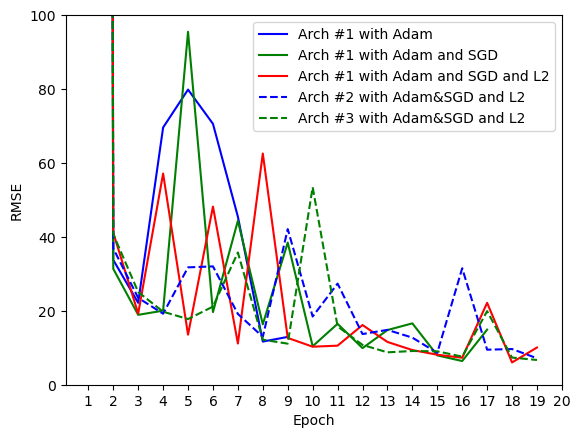

In [13]:
import matplotlib.pyplot as plt

# Define the x-axis values (number of epochs)
epochs = range(1, len(rmse_arch1_adam_sgd_l2) + 1)

# Plot the curves for each architecture/optimizer
plt.plot(range(1, len(rmse_arch1_adam) + 1), rmse_arch1_adam, 'b-', label='Arch #1 with Adam')
plt.plot(range(1, len(rmse_arch1_adam_sgd) + 1), rmse_arch1_adam_sgd, 'g-', label='Arch #1 with Adam and SGD')
plt.plot(epochs, rmse_arch1_adam_sgd_l2, 'r-', label='Arch #1 with Adam and SGD and L2')

plt.plot(epochs, rmse_arch2, 'b--', label='Arch #2 with Adam&SGD and L2')
plt.plot(epochs, rmse_arch3, 'g--', label='Arch #3 with Adam&SGD and L2')

# Add axis labels and a legend
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim(0,100)
plt.legend()

# Set the x ticks to be integers
plt.xticks(range(1, 21))

# Show the plot
plt.show()


In conclusion, based on the plot, it can be observed that the original architecture with both the Adam and SGD optimizers, along with L2 regularization, achieved the lowest root mean squared error (RMSE) among the evaluated architectures. However, it is interesting to note that architectures with fewer hidden layers and neurons, such as architecture 2 and architecture 3 (with 64 neurons in the hidden layer), also exhibited good performance. This suggests that the combination of L2 regularization and a less complex model structure can effectively prevent overfitting and lead to improved predictions of molecular energies. Therefore, when developing deep learning models for energy prediction, it is crucial to strike a balance between model complexity and regularization techniques to achieve optimal performance.

____

## Conclusion


In conclusion, the process of developing and training a deep learning model for energy prediction using the TorchANI module and sample code provided significant insights and challenges. Loading the data correctly and preparing it for input into the model was a crucial step, and the sample code and TorchANI module proved to be valuable resources in overcoming this challenge.

The incorporation of the self-energy subtraction technique was found to be essential for achieving improved training results and significantly reducing the root mean squared error (RMSE) from thousands to single digits. This technique helped to account for the inherent self-interaction energy within the model.

Furthermore, the decision to include the AEV (Atom Environment Vector) computer within the model architecture was found to greatly enhance the training performance, with a significant reduction in training time by approximately 60 times. This optimization allowed for more efficient processing of the input data and improved the overall model performance.

However, the issue of overfitting persisted even with the implementation of L2 regularization and a reduction in model complexity. While these measures helped mitigate overfitting to some extent, further exploration and experimentation with additional regularization techniques may be necessary to achieve optimal model performance.

last but not lease, the development and training of the deep learning model for energy prediction showcased the challenges and advancements in the field. While notable progress was made in terms of data loading, self-energy subtraction, and model optimization, addressing the issue of overfitting remains a future area of focus to improve the model's generalization capability.